In [8]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
reload(mlutils)
import pickle
%matplotlib inline

## Observa los filtros de primer nivel de AlexNet

Red Preentrenada: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

[Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/)

[ImageNet](http://www.image-net.org)

(11, 11, 3, 96)


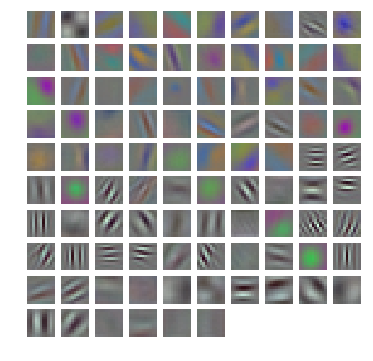

In [23]:
alex_w1 = pickle.load( open( "data/alexnet_w1.pkl", "rb" ) )
print alex_w1.shape
mlutils.display_imgs(alex_w1)


### Vamos a usarlos como punto de partida para el entrenamiento de nuestra red

In [10]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [11]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

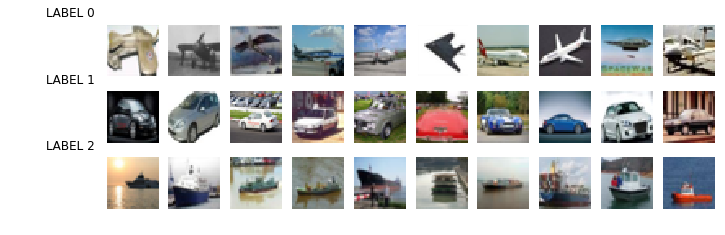

In [12]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    767
1    746
0    740
dtype: int64

distribution of test classes
0    265
2    258
1    228
dtype: int64


In [17]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [18]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}



In [20]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0    

## Transfer learning!!!

- Importamos el valor de los filtros de primer nivel


In [35]:
w = model.get_weights()
for i in w:
    print i.shape

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


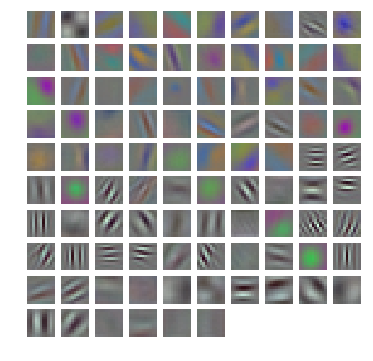

In [28]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [29]:
model.set_weights(w)

In [31]:
train(model, batch_size=32, epochs=10, model_name="model_C")

Train on 2253 samples, validate on 751 samples
Epoch 1/10
2253/2253 [==============================] - 16s 7ms/step - loss: 0.9756 - acc: 0.4931 - val_loss: 0.8788 - val_acc: 0.6205
Epoch 2/10
2253/2253 [==============================] - 16s 7ms/step - loss: 0.8127 - acc: 0.6032 - val_loss: 0.7809 - val_acc: 0.6525
Epoch 3/10
2253/2253 [==============================] - 16s 7ms/step - loss: 0.7360 - acc: 0.6538 - val_loss: 0.6787 - val_acc: 0.7470
Epoch 4/10
2253/2253 [==============================] - 15s 7ms/step - loss: 0.6640 - acc: 0.6973 - val_loss: 0.6521 - val_acc: 0.7324
Epoch 5/10
2253/2253 [==============================] - 15s 7ms/step - loss: 0.6329 - acc: 0.7057 - val_loss: 0.6115 - val_acc: 0.7483
Epoch 6/10
2253/2253 [==============================] - 16s 7ms/step - loss: 0.5633 - acc: 0.7577 - val_loss: 0.5565 - val_acc: 0.7909
Epoch 7/10
2253/2253 [==============================] - 16s 7ms/step - loss: 0.5338 - acc: 0.7736 - val_loss: 0.5677 - val_acc: 0.7776
Epoch 8/

{'acc': 0.7749667111312978, 'loss': 0.5710916052883697}

observa que los filtros de primer nivel cambiaron, pero muy poco

In [33]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.01240117

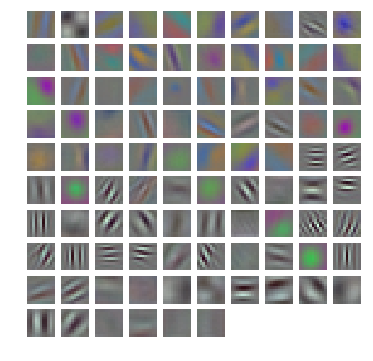

In [34]:
mlutils.display_imgs(w[0])